## **Langgraph node connections and states**

* Nodes accesses and returns states (Message passing technique)
* As long as a state is updated in any of the nodes, that state can be accessed in any of the subsequent nodes. No need to get the state from the return value of the previous node
* All states can be accessed from any of the nodes as long as the state is updated previously regardless of the previous node's return value
* Each node can return any state as long as it is defined (Not required for the state to be passed as a parameter in the node definition)

In [1]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

In [2]:
class InputState(TypedDict):
    input: str

class IntermediateState(TypedDict):
    need_human_input: bool
    inquiry: str

class OverallState(TypedDict):
    input: str
    output: str

class OutputState(TypedDict):
    output: str

In [3]:
builder = StateGraph(OverallState, input=InputState, output=OutputState)

In [4]:
import random

def node1(state: InputState) -> OverallState:
    return {"input": state["input"] + " updated", "output" : "Start"}

def intermediate_update(state: OverallState) -> IntermediateState:
    human_input_needed = random.choice([True, False])
    inquiry = state["input"] + " " + state["output"]

    return {"need_human_input": human_input_needed, "inquiry": inquiry}

def node2(state: IntermediateState) -> OutputState:
    return {"output": state["inquiry"] + " Human input needed"}

def output_update(state: IntermediateState) -> OutputState:
    output = state["inquiry"] + " Human input not needed"
    
    return {"output": output}

def decide(state: IntermediateState):
    if state["need_human_input"]:
        return "node2"
    else:
        return "output_node"

builder.add_node("node1", node1)
builder.add_node("decision_node", intermediate_update)
builder.add_node("node2", node2)
builder.add_node("output_node", output_update)

builder.add_edge(START, "node1")
builder.add_edge("node1", "decision_node")
builder.add_edge(["output_node", "node2"], END)

builder.add_conditional_edges("decision_node", decide)

graph = builder.compile()

In [5]:
print(graph.get_graph().draw_ascii())

                    +-----------+                 
                    | __start__ |                 
                    +-----------+                 
                          *                       
                          *                       
                          *                       
                      +-------+                   
                      | node1 |                   
                      +-------+                   
                          .                       
                          .                       
                          .                       
                  +---------------+               
                  | decision_node |               
                  +---------------+.              
              ....        .         ....          
          ....            .             ...       
        ..                .                ....   
+-------+         +-------------+              .. 
| node2 |*        | output_node

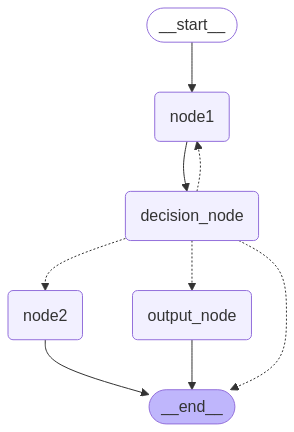

In [6]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [7]:
graph.invoke({"input" : "Hi"})

{'output': 'Hi updated Start Human input not needed'}

In [8]:
graph.invoke({"input": "Hello"})

{'output': 'Hello updated Start Human input needed'}

In [9]:
graph.invoke({"input": "Hello"})

{'output': 'Hello updated Start Human input needed'}

In [10]:
graph.invoke({"input": "Hello"})

{'output': 'Hello updated Start Human input needed'}

In [11]:
graph.invoke({"input": "Hello"})

{'output': 'Hello updated Start Human input not needed'}

## **Langgraph stray node testing for background task**

* End node will only get executed after the stray node execution is done. Not possible to use it for background tasks

In [12]:
class TempState(TypedDict):
    temp: str

In [38]:
builder2 = StateGraph(OverallState, input = InputState, output = OutputState)

In [39]:
import time

def nodex(state: InputState) -> OverallState:
    print("x")
    return {"input": state["input"] + " updated", "output": "Start"}

def nodey(state: OverallState) -> OverallState:
    print("y")
    return {"input": state["input"] + " updated", "output": state["output"] + " updated"}

def stray_node(state: OverallState):
    time.sleep(2)
    print("stray")

def nodez(state: OverallState) -> OutputState:
    print("z")
    return {"output": state["output"] + " End"}

builder2.add_node("nodex", nodex)
builder2.add_node("nodey", nodey)
builder2.add_node("stray_node", stray_node)
builder2.add_node("nodez", nodez)

builder2.add_edge(START, "nodex")
builder2.add_edge("nodex", "nodey")
builder2.add_edge("nodex", "stray_node")
builder2.add_edge("nodey", "nodez")
builder2.add_edge("nodez", END)

graph2 = builder2.compile()

In [40]:
print(graph2.get_graph().draw_ascii())

           +-----------+           
           | __start__ |           
           +-----------+           
                 *                 
                 *                 
                 *                 
             +-------+             
             | nodex |             
             +-------+             
            **        **           
          **            **         
         *                *        
+------------+         +-------+   
| stray_node |         | nodey |   
+------------+         +-------+   
                            *      
                            *      
                            *      
                       +-------+   
                       | nodez |   
                       +-------+   
                            *      
                            *      
                            *      
                      +---------+  
                      | __end__ |  
                      +---------+  


In [41]:
graph2.invoke({"input" : "Hi"})

x
y
stray
z


{'output': 'Start updated End'}

## **Updating and returning multiple states**

* Return value of each node is expected to be a dict. Not possible to return multiple dicts as a list
* To update or return multiple dicts from one node, need to define an intermediate state that has those multiple states as parameters

In [74]:
class Input(TypedDict):
    input: str

class State1(TypedDict):
    var1: str

class State2(TypedDict):
    var2: str

class State12(TypedDict):
    state1: State1
    state2: State2

class State3(TypedDict):
    var3: str

class State4(TypedDict):
    var4: str

class Output(TypedDict):
    output: str

class State34O(TypedDict):
    state3: State3
    state4: State4
    output: Output

class Overall(TypedDict):
    temp: str

In [78]:
builder3 = StateGraph(Overall, input = Input, output = State34O)

In [79]:
def nodep(state: Input) -> State12:
    state1 = State1(var1 = state["input"] + " 1")
    state2 = State2(var2 = state["input"] + " 2")

    return {"state1": state1, "state2": state2}

def nodeq(state: State12) -> State34O:
    state3 = state["state1"]["var1"] + " 3"
    state4 = state["state2"]["var2"] + " 4"
    output = {"output" : "output"}
    
    return {"state3": state3, "state4": state4, "output": output}

builder3.add_node("nodep", nodep)
builder3.add_node("nodeq", nodeq)

builder3.add_edge(START, "nodep")
builder3.add_edge("nodep", "nodeq")
builder3.add_edge("nodeq", END)

graph3 = builder3.compile()

In [80]:
graph3.invoke({"input" : "Hi"})

{'state3': 'Hi 1 3', 'state4': 'Hi 2 4', 'output': {'output': 'output'}}

* Error specifying that the return state is expected to be a dict and not a list

In [110]:
builder4 = StateGraph(Overall, input = Input, output = list[State3, State4, Output])

In [111]:
def noder(state: Input) -> State12:
    print("r")
    state1 = State1(var1 = state["input"] + " 1")
    state2 = State2(var2 = state["input"] + " 2")

    return {"state1": state1, "state2": state2}

def nodes(state: State12) -> list[State3, State4, Output]:
    print("s")
    state3 = {"var3": state["state1"]["var1"] + " 3"}
    state4 = {"var4": state["state2"]["var2"] + " 4"}
    output = {"output" : "output"}
    
    return [state3, state4, output]

builder4.add_node("noder", noder)
builder4.add_node("nodes", nodes)

builder4.add_edge(START, "noder")
builder4.add_edge("noder", "nodes")
builder4.add_edge("nodes", END)

graph4 = builder4.compile()

In [112]:
graph4.invoke({"input" : "Hi"})

r
s


InvalidUpdateError: Expected dict, got [{'var3': 'Hi 1 3'}, {'var4': 'Hi 2 4'}, {'output': 'output'}]
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

## **State passing through nodes**

* Here, node a is connected to node b which is connected to node c
* node a expects Input and returns State1; nodeb expects State1 and returns Overall, nodec expects State1 returns Output
* Even though node b is connected to node c, node b returns Overall and nodec expects State1; we don't run into an error
* State1 is already updated by node a. So, even though node c is not getting that state from it's connected node (node b) it is still able to access it
* No matter how many nodes are connected after node c, all of them can access State 1 regardless of whether their previous connected nodes are returning that state
* Similarly any other state which was not updated (State2, State3, ...) cannot be accessed in their subsequent nodes

In [130]:
builder5 = StateGraph(Overall, input = Input, output = Output)

In [131]:
def nodea(state: Input) -> State1:
    print("a")
    return {"var1": state["input"] + " a"}

def nodeb(state: State1) -> Overall:
    print("b")
    return {"temp": state["var1"] + " b"}

def nodec(state: State1) -> Output:
    print("c")
    return {"output": state["var1"] + " c"}

builder5.add_node("nodea", nodea)
builder5.add_node("nodeb", nodeb)
builder5.add_node("nodec", nodec)

builder5.add_edge(START, "nodea")
builder5.add_edge("nodea", "nodeb")
builder5.add_edge("nodeb", "nodec")
builder5.add_edge("nodec", END)

graph5 = builder5.compile()

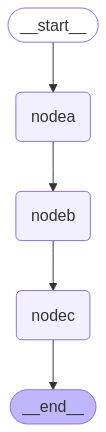

In [132]:
Image(graph5.get_graph().draw_mermaid_png())

In [144]:
graph5.invoke({"input": "Hi"})

a
b
c


{'output': 'Hi a c'}